In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor 
np.random.seed(0)


from tqdm import tqdm
from scikitplot.estimators import plot_learning_curve
from sklearn.model_selection import cross_val_score, KFold
from sklearn.externals import joblib
from eli5.xgboost import explain_weights_xgboost
from sklearn.model_selection import train_test_split


import xgboost as xgb
from ml_metrics import rmsle

In [96]:
cd Desktop\nieruchomosci

[WinError 3] System nie może odnaleźć określonej ścieżki: 'Desktop\\nieruchomosci'
C:\Users\adria\Desktop\nieruchomosci


In [97]:

test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

train.shape

(70488, 20)

In [98]:
df = pd.concat([train,test])


In [99]:
df.dtypes

Unnamed: 0               int64
numer_oferty             int64
kiedy_dodano            object
kiedy_aktualizowano     object
typ_oferty              object
lokalizacja             object
cena                   float64
liczba_pokoi            object
pietro                  object
ogrzewanie              object
rodzaj_zabudowy         object
material_budynku        object
stan_wykonczenia        object
powierzchnia           float64
link_ogloszenia         object
okna                    object
dostepne_od             object
id_oferty               object
miasto                  object
wojewodztwo             object
dtype: object

In [100]:

num_feat = ['liczba_pokoi','pietro','powierzchnia','cena']

## Convert string to numbers

for feat in num_feat:
    try:
        df[feat] = df[feat].astype(np.int)
    except:
        try:
            
            df[feat] = df[feat].astype(np.float)
        except: 
            print("Error:", feat)


Error: liczba_pokoi
Error: pietro


In [101]:
df['pietro'].value_counts()

 1           19442
 parter      15992
 2           15265
 3           13794
 4            9543
 5            3577
 6            2170
 7            1547
 8            1096
 &gt; 10      1040
 10            910
 9             866
 poddasze      100
 suterena       44
Name: pietro, dtype: int64

In [102]:
df['liczba_pokoi'] = df['liczba_pokoi'].str.strip().str.replace('więcej niż 10',"11").astype(np.int)
df['pietro'] = df['pietro'].str.replace('&gt; ','').str.replace('parter','0').str.replace('poddasze','11').str.replace('suterena','12').astype(np.float)


floor_dict = {
    'poddasze': 11,
    'suterena': 12,
    'więcej niż 10': 11
}



df[num_feat]

,liczba_pokoi,pietro,powierzchnia,cena
0,5,1.0,84,690000.0
1,2,0.0,45,380000.0
2,2,1.0,36,259000.0
3,3,0.0,73,598600.0
4,2,4.0,41,500000.0
...,...,...,...,...
17616,1,6.0,26,NaN
17617,4,0.0,85,NaN
17618,2,3.0,48,NaN
17619,4,0.0,69,NaN


In [103]:
## Label encoding
black_list = ['lokalizacja','numer_oferty','link_ogloszenia','id_oferty']
cat_feat = ['kiedy_dodano','kiedy_aktualizowano','typ_oferty','ogrzewanie','rodzaj_zabudowy','material_budynku','stan_wykonczenia','okna','dostepne_od','miasto','wojewodztwo']


for feat in cat_feat:
    new_name = '{}_cat'.format(feat.lower().replace(' ','_').replace(':',""))
    df[new_name] = df[feat].factorize()[0] 

In [104]:
## selecting features

select_feat = df.select_dtypes(include = np.number).columns

print(select_feat)

remove = ['numer_oferty','cena/metr','cena','Unnamed: 0']

select_feat = [feat for feat in select_feat if feat not in  remove]
select_feat

Index(['Unnamed: 0', 'numer_oferty', 'cena', 'liczba_pokoi', 'pietro',
       'powierzchnia', 'kiedy_dodano_cat', 'kiedy_aktualizowano_cat',
       'typ_oferty_cat', 'ogrzewanie_cat', 'rodzaj_zabudowy_cat',
       'material_budynku_cat', 'stan_wykonczenia_cat', 'okna_cat',
       'dostepne_od_cat', 'miasto_cat', 'wojewodztwo_cat'],
      dtype='object')


['liczba_pokoi',
 'pietro',
 'powierzchnia',
 'kiedy_dodano_cat',
 'kiedy_aktualizowano_cat',
 'typ_oferty_cat',
 'ogrzewanie_cat',
 'rodzaj_zabudowy_cat',
 'material_budynku_cat',
 'stan_wykonczenia_cat',
 'okna_cat',
 'dostepne_od_cat',
 'miasto_cat',
 'wojewodztwo_cat']

In [105]:
df_train = df[select_feat].iloc[:70487,]
df_test =  df[select_feat].iloc[70487:,]

X_train = df_train.values
X_test = df_test.values
y_train = df.loc[:70486,'cena'].values



In [106]:
## Train model

model = xgb.XGBRegressor(max_depth=8, n_estimators = 100)
model.fit(X_train,y_train)
joblib.dump(model, "model.joblib.dat")
loaded_model = joblib.load("model.joblib.dat")

def custom_rmsle(model,X_test,y_test):
    y_pred = loaded_model.predict(X_test) ## why does not the model want to work ?
    y_pred[y_pred < 0] = 0
    return rmsle (y_pred,y_test )

## Cross validation

cross_val_score(model,X_train,y_train, cv = 5, scoring = custom_rmsle) 


array([0.1760567 , 0.19343971, 0.19709829, 0.13213411, 0.16006768])

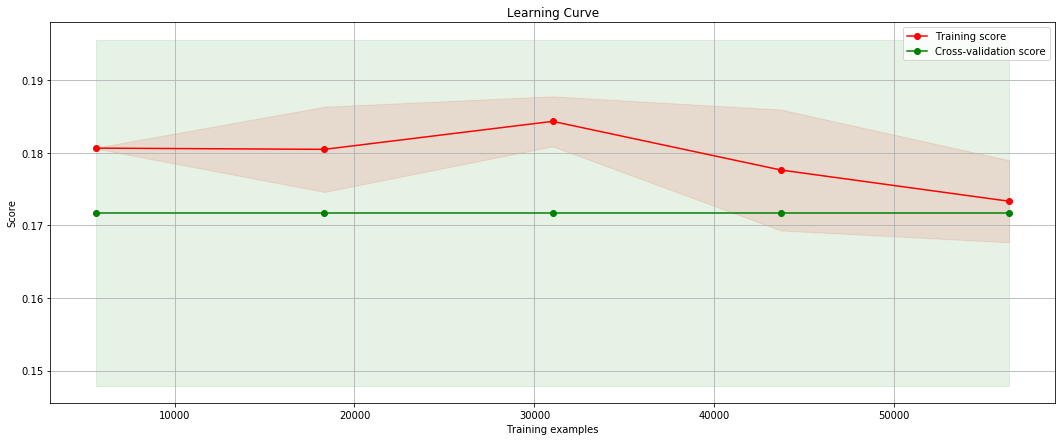

In [107]:
##learning curve

model = xgb.XGBRegressor( **{'max_depth':8, 'n_estimators':100})
plot_learning_curve(model,X_train,y_train, cv = 5,scoring = custom_rmsle, figsize = (18,7))


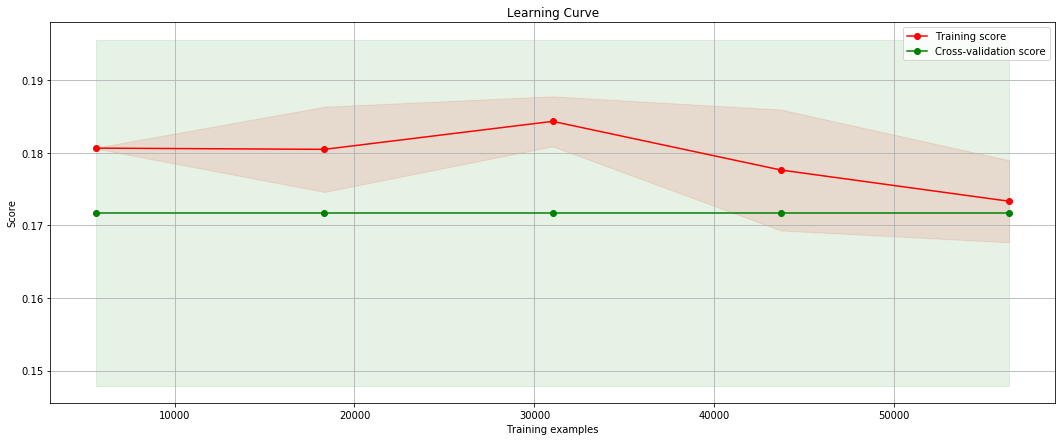

In [108]:
xgb_params = {'max_depth':10, 'n_estimators':200, 'seed':0,'subsample':0.8}

model = xgb.XGBRegressor( **xgb_params )
plot_learning_curve(model,X_train,y_train, cv = 5,scoring = custom_rmsle, figsize = (18,7))

In [114]:
## Weight of features
from eli5 import show_weights
model = xgb.XGBRegressor( **xgb_params )
model.fit(X_train,y_train)
print(model.feature_importances_)
#explain_weights_xgboost(model,feature_names =select_feat, importance_type ='gain', top = 3 )

[0.04612888 0.05525292 0.17953128 0.04228528 0.01724964 0.01793614
 0.01997462 0.06715591 0.0234274  0.02727536 0.03008489 0.07546719
 0.03410011 0.36413044]


In [135]:

## Weight of features
columns = df_train.columns
importance = model.feature_importances_

frame = pd.DataFrame({'name':columns,'importance':importance})
frame.sort_values(by=['importance'],ascending = False, inplace = True)
frame.name = frame.name.str.replace('_cat',"")
frame

,name,importance
13,wojewodztwo,0.364130
2,powierzchnia,0.179531
11,dostepne_od,0.075467
7,rodzaj_zabudowy,0.067156
1,pietro,0.055253
0,liczba_pokoi,0.046129
3,kiedy_dodano,0.042285
12,miasto,0.034100
10,okna,0.030085
9,stan_wykonczenia,0.027275


In [79]:
def run_cv(X,y,model_class,model_params={},cv=3):
    
    cv = KFold(n_splits = cv)
    
    scores = []
    for train_id, test_id in cv.split(X):
        X_local_train, X_local_test = X[train_id], X[test_id]
        y_local_train, y_local_test = y[train_id], y[test_id]
        
        y_log_local_train = np.log(y_local_train)
        
        model = model_class(**model_params)
        model.fit(X_local_train,y_local_train)
        y_log_pred = model.predict(X_local_test)
        y_pred = np.exp(y_log_pred)
        score = rmsle(y_local_test,y_pred)
        scores.append(score)
    
    return scores

run_cv(X_train,y_train,xgb.XGBRegressor,{'max_depth':8, 'n_estimators': 100},cv=3)

[inf, inf, inf]

In [167]:
## create a dict labels assign to factorize ID

df['typ_oferty_cat'], labels = df['typ_oferty'].factorize()
dict_typ_oferty = {value: id_ for id_,value in enumerate(labels)}


df['wojewodztwo_cat'], labels = df['wojewodztwo'].factorize()
dict_wojewodztwo = {value: id_ for id_,value in enumerate(labels)}

df['dostepne_od_cat'], labels = df['dostepne_od'].factorize()
dict_dostep = {value: id_ for id_,value in enumerate(labels)}

df['rodzaj_zabudowy_cat'], labels = df['rodzaj_zabudowy'].factorize()
dict_zabudowa = {value: id_ for id_,value in enumerate(labels)}

df['pietro_cat'], labels = df['pietro'].factorize()
dict_pietro = {value: id_ for id_,value in enumerate(labels)}

df['liczba_pokoi_cat'], labels = df['liczba_pokoi'].factorize()
dict_pokoje = {value: id_ for id_,value in enumerate(labels)}

df['miasto_cat'], labels = df['miasto'].factorize()
dict_miasto = {value: id_ for id_,value in enumerate(labels)}
dict_pokoje

{5: 0, 2: 1, 3: 2, 4: 3, 1: 4, 6: 5, 11: 6, 9: 7, 10: 8, 7: 9, 8: 10}

In [162]:
best_feats = ['typ_oferty_cat','wojewodztwo_cat','dostepne_od_cat','rodzaj_zabudowy_cat','pietro_cat','liczba_pokoi_cat','miasto_cat']

x_train = df[best_feats].iloc[:70487,].values
x_test = df[best_feats].iloc[70487:,].values
Y_train = df.loc[:70486,'cena'].values
Y_log_train = np.log(Y_train)

model = xgb.XGBRegressor( **xgb_params )
model.fit(x_train,Y_log_train)


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=0, subsample=0.8,
             tree_method=None, validate_parameters=False, verbosity=None)

In [179]:
## Let's check if models work correctly 
typ_oferty_cat = 'Oferta dewelopera'
wojewodztwo_cat = 'ŁD'
dostepne_od_cat = ' 2020-06-30'
rodzaj_zabudowy_cat = ' blok'
pietro_cat = 3
liczba_pokoi_cat = 2
miasto_cat = 'Radomsko'

xx = np.array([[dict_typ_oferty[typ_oferty_cat],
                dict_wojewodztwo[wojewodztwo_cat],
                dict_dostep[dostepne_od_cat],
                dict_zabudowa[rodzaj_zabudowy_cat],
                pietro_cat,
                liczba_pokoi_cat,
                dict_miasto[miasto_cat]
    
               ]])

xx

array([[10,  2, 29,  0,  3,  2, 65]])

In [186]:
model.predict(xx) ## models return logarithm value 



array([12.417556], dtype=float32)

In [187]:
np.exp(model.predict(xx))

array([247101.83], dtype=float32)

In [188]:
joblib.dump(model, "models.joblib.dat")

['models.joblib.dat']

In [190]:
## We have to pay about 247101.83 zł for a flat in Radomsko,
#  located in 3th floor in the block with 2 rooms.

check_models = joblib.load("models.joblib.dat")

np.exp(check_models.predict(xx))

array([247101.83], dtype=float32)

In [201]:
typ_oferty_cat = 'Oferta dewelopera'
wojewodztwo_cat = 'MZ'
dostepne_od_cat = ' 2020-06-30'
rodzaj_zabudowy_cat = ' blok'
pietro_cat = 3
liczba_pokoi_cat = 2
miasto_cat = 'Warszawa'

pp = np.array([[dict_typ_oferty[typ_oferty_cat],
                dict_wojewodztwo[wojewodztwo_cat],
                dict_dostep[dostepne_od_cat],
                dict_zabudowa[rodzaj_zabudowy_cat],
                pietro_cat,
                liczba_pokoi_cat,
                dict_miasto[miasto_cat]
    
               ]])



pp

array([[  2,   2,  29,   0,   3,   2, 340]])

In [202]:
model.predict(pp)

array([13.3486185], dtype=float32)

In [203]:
np.exp(model.predict(pp))

array([626947.75], dtype=float32)